# Segmentation model inference Switzerland

In [ ]:
import numpy as np
import pandas as pd
import pyreadr as pyr
from sys import getsizeof
import random
import cv2
import os
from skimage import io
from scipy.stats import ttest_ind
import matplotlib as mpl
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_addons as tfa
import keras
import segmentation_models as sm 
from keras.metrics import MeanIoU
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from patchify import patchify

sm.set_framework('tf.keras')
sm.framework()
random_seed = 1234

In this file the pretrained model ensemble is used for inference in Switzerland. The land cover is predicted based on the satellite images that are representing the respondents' neighborhood.

In [ ]:
# set up dir

dir_rs = "YOUR_DIRECTORY/"

In [2]:
with tf.device('/cpu:0'): 
    model_names=["effnetb4_focc_jacc_10", "effnetb4_focc_jacc_11", "effnetb4_focc_jacc_12", "effnetb4_focc_jacc_13", "effnetb4_focc_jacc_14"]
    backbone="effnetb4"
    n_classes = 9
    lr = 0.0001
    decay = 0.000001

    metrics = [tf.keras.metrics.CategoricalAccuracy(name="cat_accuracy"),
               sm.metrics.IOUScore(threshold=0.5, class_indexes=[1,2,3,4,5,6,7,8]),
               sm.metrics.FScore(threshold=0.5, class_indexes=[1,2,3,4,5,6,7,8]),
               tf.keras.metrics.MeanIoU(num_classes=n_classes)]


    ## Load U-net backbone
    backbone_model = keras.models.load_model(dir_rs + "u_net_models/model_u_%s_image_net_weights.hdf5" %backbone)


    ## Define loss    
    dice_loss = sm.losses.DiceLoss(class_indexes=[1,2,3,4,5,6,7,8])


    ## Define optimizer
    optimizer = tfa.optimizers.AdamW(learning_rate=lr, weight_decay=decay)

       
        
    ## Load and compile models  
    bb_model_1 = keras.models.clone_model(backbone_model)
    bb_model_1.compile(optimizer=optimizer,loss=dice_loss,metrics=metrics)
    bb_model_1.load_weights(dir_rs + "Data_sets/image_segmentation/u_net_models_mc/u_net_%s" %model_names[0])
    
    bb_model_2 = keras.models.clone_model(backbone_model)
    bb_model_2.compile(optimizer=optimizer,loss=dice_loss,metrics=metrics)
    bb_model_2.load_weights(dir_rs + "Data_sets/image_segmentation/u_net_models_mc/u_net_%s" %model_names[1])
    
    bb_model_3 = keras.models.clone_model(backbone_model)
    bb_model_3.compile(optimizer=optimizer,loss=dice_loss,metrics=metrics)
    bb_model_3.load_weights(dir_rs + "Data_sets/image_segmentation/u_net_models_mc/u_net_%s" %model_names[2])
    
    bb_model_4 = keras.models.clone_model(backbone_model)
    bb_model_4.compile(optimizer=optimizer,loss=dice_loss,metrics=metrics)
    bb_model_4.load_weights(dir_rs + "Data_sets/image_segmentation/u_net_models_mc/u_net_%s" %model_names[3])
    
    bb_model_5 = keras.models.clone_model(backbone_model)
    bb_model_5.compile(optimizer=optimizer,loss=dice_loss,metrics=metrics)
    bb_model_5.load_weights(dir_rs + "Data_sets/image_segmentation/u_net_models_mc/u_net_%s" %model_names[4])


    ## Test time augmentation for single image
    def TTA(bb_model, img):

        p0 = bb_model.predict(img)

        p1 = bb_model.predict(np.fliplr(img))
        p1 = np.fliplr(p1)

        p2 = bb_model.predict(np.flipud(img))
        p2 = np.flipud(p2)

        p3 = bb_model.predict(np.fliplr(np.flipud(img)))
        p3 = np.fliplr(np.flipud(p3))

        avg_pred = (p0 + p1 + p2 + p3)/4
        return avg_pred
    
    
    ## Average ensemble prediction
    def model_ensemble(img, bb_m1, bb_m2, bb_m3, bb_m4, bb_m5):
        pred_ensemble=[] 
        pred_ensemble.append(np.array(TTA(bb_m1, img))[0,:,:,:])
        pred_ensemble.append(np.array(TTA(bb_m2, img))[0,:,:,:])
        pred_ensemble.append(np.array(TTA(bb_m3, img))[0,:,:,:])
        pred_ensemble.append(np.array(TTA(bb_m4, img))[0,:,:,:])
        pred_ensemble.append(np.array(TTA(bb_m5, img))[0,:,:,:])
        return np.mean(np.array(pred_ensemble), axis=0)
    

## Images close proximity (420m x 420m)

In [2]:
images = np.load(dir_rs + "CH_images/images_center_1024.npy")
images.shape

(4658, 1024, 1024, 3)

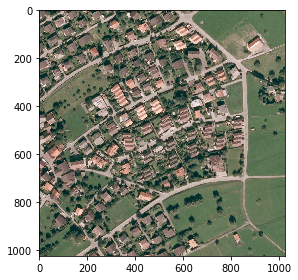

In [5]:
io.imshow(images[0])

In [ ]:
with tf.device('/cpu:0'):
    img_count_ten=0
    img_count=0
    segm_list = []
    
    for img in images:
        pred_list = []
        patchified_img = patchify(img, (512, 512, 3), step=512)
        for k in range(patchified_img.shape[0]):
            for j in range(patchified_img.shape[1]):
                segm_input = patchified_img[k, j,0,:, :, :]
                pred_list.append(model_ensemble(np.expand_dims(segm_input, axis=0), bb_model_1, bb_model_2, 
                                                bb_model_3, bb_model_4, bb_model_5))

        pred_list = np.array(pred_list)
        horiz_1 = np.hstack([pred_list[0], pred_list[1]])
        horiz_2 = np.hstack([pred_list[2], pred_list[3]])
        segm_list.append(np.vstack([horiz_1, horiz_2]))
        
        img_count_ten += 1
        if img_count_ten == 10:
            img_count += 1
            img_count_ten=0
            print(img_count)
        
    segm_list = np.array(segm_list) 

In [10]:
segm_list.shape

(2358, 1024, 1024, 9)

In [11]:
np.save(dir_rs + "CH_images/mask_center_9d.npy", segm_list)

In [12]:
segm_list = np.argmax(segm_list, axis=-1)
segm_list.shape

(2358, 1024, 1024)

In [13]:
np.save(dir_rs + "CH_images/mask_center_all.npy", segm_list)

## Images larger neighborhood (1620m x 1620m)

In [7]:
images = np.load(dir_rs + "CH_images/images_stacked_3072.npy")

In [ ]:
with tf.device('/gpu:0'):
    img_count_ten=0
    img_count=0
    segm_list = []
    
    for img in images[:10]:
        pred_list = []
        patchified_img = patchify(img, (512, 512, 3), step=512)
        for k in range(patchified_img.shape[0]):
            for j in range(patchified_img.shape[1]):
                segm_input = patchified_img[k, j,0,:, :, :]
                pred_list.append(model_ensemble(np.expand_dims(segm_input, axis=0), bb_model_1, bb_model_2, 
                                                bb_model_3, bb_model_4, bb_model_5))

        horiz_1 = np.hstack([pred_list[0], pred_list[1], pred_list[2], pred_list[3], pred_list[4], pred_list[5]])
        horiz_2 = np.hstack([pred_list[6], pred_list[7], pred_list[8], pred_list[9], pred_list[10], pred_list[11]])
        horiz_3 = np.hstack([pred_list[12], pred_list[13], pred_list[14], pred_list[15], pred_list[16], pred_list[17]])
        horiz_4 = np.hstack([pred_list[18], pred_list[19], pred_list[20], pred_list[21], pred_list[22], pred_list[23]])
        horiz_5 = np.hstack([pred_list[24], pred_list[25], pred_list[26], pred_list[27], pred_list[28], pred_list[29]])
        horiz_6 = np.hstack([pred_list[30], pred_list[31], pred_list[32], pred_list[33], pred_list[34], pred_list[35]])
        segm_list.append(np.vstack([horiz_1, horiz_2, horiz_3,
                                   horiz_4, horiz_5, horiz_6]))
        
        img_count_ten += 1
        if img_count_ten == 10:
            img_count += 1
            img_count_ten=0
            print(img_count)
        
    segm_list = np.array(segm_list) 

In [ ]:
np.save(dir_rs + "CH_images/mask_stacked_all.npy", segm_list)

=> proceed with file ```add_land_use_data.ipynb```